# **Final Project**

IST340 Knowledge Discovery and Data Mining

Group 1: **Yuri Yu**, **Irma Covarrubias**, **Patrick Watkins**

## Load required libraries

In [49]:
import re
import pandas as pd 
pd.set_option('display.max_columns', None) 
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, BernoulliNB

import warnings
warnings.filterwarnings("ignore")

## Working directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File path set and defined to Google Drive where Merged Data File is stored
file_path = '/content/drive/MyDrive/IST340_Spring_Lab/'

## Load Merged Data Set

In [4]:
df = pd.read_csv(file_path + 'merged_raw_data.csv')
df.head(10)

,StudentID,NoPaymentDue,Enlisted,Enrolled,Service,School,Units,Disabled,Unemployed,Country,Region,Marital_Status,Gender,Longest_Absence_From_School,Filed_For_Bankruptcy,LongTermPlanningScore,DecisionStyle,PowerOrientedScore,CommunityOrientedScore,Family_Income,Parent_Education_Level,Credit_Score_Raw,Credit_Score_AgeAdj,Loan_Amount,HS_Math,HS_Science,HS_English
0,1000,pos,1,1,air_force,ucsd;occ,14.0,NaN,Unemployed,USA,1,1,NaN,7,NaN,0.843289,Emotional,0.808111,0.569837,54206.48,Bachelor's,0.639912,0.808111,16823,10.0,10.0,9.0
1,999,pos,1,1,fire_department,smc,4.0,NaN,NaN,USA,2,1,NaN,4,Filed_For_Bankruptcy,0.662624,Analytical,1.000000,0.004697,65238.16,HS or Lower,0.989682,0.597839,16943,9.0,9.0,6.0
2,998,pos,0,1,NaN,ucb;smc,2.0,NaN,NaN,USA,5,0,NaN,1,Filed_For_Bankruptcy,0.994214,Analytical,0.855013,0.441015,67495.76,Doctorate,0.777285,0.441015,6178,8.0,9.0,5.0
3,996,pos,1,1,navy,smc,11.0,NaN,Unemployed,USA,3,1,NaN,7,NaN,0.889289,Emotional,0.780557,0.301059,83784.09,HS or Lower,0.612762,0.780557,17924,9.0,10.0,10.0
4,994,pos,0,1,NaN,uci,9.0,NaN,NaN,USA,3,1,Male,1,NaN,0.860842,Emotional,0.829191,0.467755,104457.91,Doctorate,0.585587,0.829191,19106,9.0,9.0,4.0
5,993,pos,1,1,fire_department,ucb,6.0,NaN,Unemployed,USA,1,0,NaN,4,NaN,0.809411,Emotional,0.767735,0.044467,99421.84,Bachelor's,0.473408,0.767735,17135,7.0,8.0,7.0
6,992,pos,1,1,marines,ucsd;smc,12.0,Disabled,NaN,USA,3,0,Male,7,NaN,0.941271,Emotional,0.806621,0.552842,85207.17,HS or Lower,0.655463,0.806621,18260,9.0,10.0,8.0
7,990,pos,0,1,NaN,smc,10.0,NaN,NaN,USA,3,1,NaN,4,NaN,0.553502,Emotional,0.561046,0.477419,76995.90,Bachelor's,0.510042,0.477419,19735,6.0,6.0,7.0
8,989,pos,0,1,NaN,ucla,12.0,NaN,NaN,USA,3,0,NaN,9,NaN,0.693413,Emotional,0.632762,0.632761,58579.26,HS or Lower,0.525709,0.632762,19899,10.0,10.0,8.0
9,987,pos,0,1,NaN,occ,12.0,NaN,NaN,USA,3,1,Male,5,NaN,0.824561,Emotional,0.785739,0.785739,100373.38,Doctorate,0.501800,0.785739,19587,7.0,8.0,8.0


## Data Preparation

In [5]:
# Create a copy of the data frame to the data prep
df_agg = df.copy()

### Select Data

#### Drop Useless Variables

In [6]:
# StudentID is a unique identifier, and thus, useless for modeling, so we'll drop this variable as well.
# USA accounts for most of the records and 1 record is Belize, if we drop Belize, we are left with USA which is useless for modeling, so we will drop Country variable
df_agg.drop(['StudentID', 'Country'], axis=1, inplace=True)
print(df_agg.columns)

Index(['NoPaymentDue', 'Enlisted', 'Enrolled', 'Service', 'School', 'Units',
       'Disabled', 'Unemployed', 'Region', 'Marital_Status', 'Gender',
       'Longest_Absence_From_School', 'Filed_For_Bankruptcy',
       'LongTermPlanningScore', 'DecisionStyle', 'PowerOrientedScore',
       'CommunityOrientedScore', 'Family_Income', 'Parent_Education_Level',
       'Credit_Score_Raw', 'Credit_Score_AgeAdj', 'Loan_Amount', 'HS_Math',
       'HS_Science', 'HS_English'],
      dtype='object')


In [8]:
# Marital_Status has a value of 2 which is only 1 record. Per the business, we can drop this record since its not single or married.
df_agg = df_agg[df_agg['Marital_Status'] != 2]
df_agg['Marital_Status'].value_counts()

1    545
0    454
Name: Marital_Status, dtype: int64

In [9]:
# Parent_Education_Level also has a value as "GREAT" for only 1 record. Per the business, we can drop it.
df_agg = df_agg[df_agg['Parent_Education_Level'] != 'GREAT']
df_agg['Parent_Education_Level'].value_counts()

Doctorate            303
Bachelor's           301
HS or Lower          284
Master's             107
VERY HS or Lower       2
 VERY HS or Lower      1
Name: Parent_Education_Level, dtype: int64

### Clean Data

#### Group Data 

In [15]:
# We will group 'HS or lower' and 'VERY HS or Lower' values together
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].apply(lambda x: 'HS or Lower' if x == ' VERY HS or Lower' else x)
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].apply(lambda x: 'HS or Lower' if x == 'VERY HS or Lower' else x)
df_agg['Parent_Education_Level'].value_counts()
# We will use ordinal encoding

Doctorate      303
Bachelor's     301
HS or Lower    287
Master's       107
Name: Parent_Education_Level, dtype: int64

In [16]:
# Since 'Loan_Amount' has many outliers that rougly form a group, we will group the data into two categorical groups
# If the Loan_Amount is less than 12000, we will group it into 0, otherwise, we will group it into 1
df_agg['Loan_Amount'] = df_agg['Loan_Amount'].apply(lambda x: 0 if x < 12000 else 1)

df_agg['Loan_Amount'].value_counts() # 1 = high loan group and 0 = low loan group

1    862
0    136
Name: Loan_Amount, dtype: int64

#### Missing value imputation with a constant value

Here, we will replace the missing values with a constant value that does not appear in the dataset.

In [17]:
# Replace the missing values in the 'Units' column with 0
df_agg['Units'].fillna(0, inplace = True)

In [18]:
# Disabled: 1, Missing Values: 0
df_agg['Disabled'] = df_agg['Disabled'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [19]:
# Unemployed: 1; Missing Values: 0
df_agg['Unemployed'] = df_agg['Unemployed'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [20]:
# Gender: Male= 1, Female = 0 (Missing Values)
df_agg['Gender'] = df_agg['Gender'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [22]:
# Bankruptcy: Yes = 1, No = 0 (Missing Values)
df_agg['Filed_For_Bankruptcy'] = df_agg['Filed_For_Bankruptcy'].apply(lambda x: 1 if pd.notnull(x) else 0)

#### Imputation using Median

In [23]:
# With 1.6% missing values in HS_English because the data right-skewed, we will replace the missing values using the median imputation method
df_agg['HS_English'].fillna(df_agg['HS_English'].median(), inplace=True) # Median = 8.0 so that we don't have to worry about the rounding float into integer

### Format Data 

Ordinal Encoding of the Data

In [24]:
df_agg['Parent_Education_Level'].value_counts()

Doctorate      303
Bachelor's     301
HS or Lower    287
Master's       107
Name: Parent_Education_Level, dtype: int64

In [25]:
# Ordinal Encoding for Parent_Education_Level: HS or Lower > Bachelor's > Master's > Doctorate
df_agg['Parent_Education_Level'] = df_agg['Parent_Education_Level'].map({'HS or Lower': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'Doctorate': 3})
df_agg['Parent_Education_Level'].value_counts()

3    303
1    301
0    287
2    107
Name: Parent_Education_Level, dtype: int64

In [26]:
# Convert the Longest_Absence_From_School variable from object to numeric
df_agg['Longest_Absence_From_School'] = df_agg['Longest_Absence_From_School'].astype('int64')

df_agg['Longest_Absence_From_School'].value_counts()

4    119
5    109
3    104
0    100
7     99
2     96
6     95
1     93
8     93
9     90
Name: Longest_Absence_From_School, dtype: int64

#### Binary Encoding

In [27]:
df_agg['DecisionStyle'].value_counts()

Emotional     912
Analytical     86
Name: DecisionStyle, dtype: int64

In [28]:
# Utilize binary encoding for the DecisionStyle variable in case we need to use some models that require numeric data
df_agg['DecisionStyle'] = df_agg['DecisionStyle'].map({'Analytical': 0, 'Emotional': 1})

df_agg['DecisionStyle'].value_counts()

1    912
0     86
Name: DecisionStyle, dtype: int64

#### Normalize the Data

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_agg['Family_Income_normalized'] = scaler.fit_transform(df_agg[['Family_Income']])

# drop the original Family_Income column
df_agg.drop(['Family_Income'], axis=1, inplace=True)

In [30]:
display(df_agg.loc[:5,'Family_Income_normalized'], df_agg.shape)

0    0.239471
1    0.377550
2    0.405808
3    0.609683
4    0.868450
5    0.805415
Name: Family_Income_normalized, dtype: float64

(998, 25)

### Construct Data

In [31]:
# Perform one-hot encoding on the 'School' column, considering the aggregated values
# Set the separator to ';'
school_dummies = df_agg['School'].str.get_dummies(sep=';')

# Add a 'School' prefix to the one-hot encoded columns
school_dummies.columns = ['School_' + col for col in school_dummies.columns]

# Concatenate the original DataFrame with the one-hot encoded columns
df_agg_encoded = pd.concat([df_agg, school_dummies], axis=1)

# Drop the original 'School' column
df_agg_encoded.drop('School', axis=1, inplace=True)

display(df_agg_encoded.iloc[:5,25:], df_agg_encoded.shape)

,School_smc,School_ucb,School_uci,School_ucla,School_ucsd
0,0,0,0,0,1
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0


(998, 30)

In [32]:
# Same as above, do one-hot encoding on the 'Service' column, considering the aggregated values
# Set the separator to ';'
service_dummies = df_agg_encoded['Service'].str.get_dummies(sep=';')

# Add a 'Service' prefix to the one-hot encoded columns
service_dummies.columns = ['Service_' + col for col in service_dummies.columns]

# Concatenate the original DataFrame with the one-hot encoded columns
df_agg_encoded = pd.concat([df_agg_encoded, service_dummies], axis=1)

# Drop the original 'Service' column
df_agg_encoded.drop('Service', axis=1, inplace=True)

display(df_agg_encoded.iloc[:5,29:], df_agg_encoded.shape)

,Service_air_force,Service_army,Service_fire_department,Service_foreign_legion,Service_marines,Service_navy,Service_peace_corps
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0


(998, 36)

In [33]:
df_agg_prep = df_agg_encoded.copy() # Save a copy of the cleaned data for Task A

# save as csv file called
df_agg_prep.to_csv(file_path + 'merge_prep_final.csv', index=False)

## Modeling

### Encode Target Variable for A1

In [34]:
# Target event is NoPaymentDue  = ‘pos’
# We will encode the target variable to 1 if NoPaymentDue = ‘pos’ else 0
df_a1 = df_agg_prep.copy()
df_a1['NoPaymentDue'] = df_agg_prep['NoPaymentDue'].map({'pos': 1, 'neg': 0})


In [35]:
# Create a function that will perform exploratory data analysis on a specified column in a DataFrame, displaying basic statistics and visualizations.
def data_exploration(df, column):
    col_type = df[column].dtype

    if col_type == 'object' or col_type == 'category': 
        unique_values = df[column].nunique()
        print(f"Counts and percentages of unique values in {column}:\n")
        count_pct = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True) * 100], axis=1)
        count_pct.columns = ['Count', 'Percentage']
        print(count_pct)
        if unique_values < 10:   
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df, x=column)
            plt.title(f"Bar chart of {column}") # Bar plot
            plt.show()
        else:
            bins_num = df[column].nunique()
            sns.histplot(data=df, x=column, bins=bins_num, kde=True) # Histogram
            plt.title(f"Histogram of {column}")
            plt.xticks(rotation=90, fontsize=7, ha="center")
            plt.show()
    
    elif df[column].nunique() >= 10:
         mean = df[column].mean() # mean
         std_dev = df[column].std() # standard deviation
         # Calculate interquartile range (IQR)
         q1 = df[column].quantile(0.25)
         q3 = df[column].quantile(0.75)
         iqr = q3 - q1 # interquartile range
         outlier_range = (q1 - 1.5*iqr, q3 + 1.5*iqr) # outlier range is 1.5 times of IQR
         outliers = df[(df[column] < outlier_range[0]) | (df[column] > outlier_range[1])]
         outliers = outliers[column].values # outlier values

         print(f"Mean of {column}: {mean:.2f}")
         print(f"Standard deviation of {column}: {std_dev:.2f}")
         print(f"Number of outliers in {column}: {len(outliers)}")
         print("Outliers values:")
         print(outliers)

         plt.figure(figsize=(8, 6))
         sns.boxplot(data=df, x=column)
         plt.title(f"Box plot of {column}") # Box plot
         
         plt.figure(figsize=(8, 6))
         sns.histplot(data=df, x=column, bins=10, kde=True) # Histogram that has 10 bins
         plt.title(f"Histogram of {column}")
         plt.show()
    else:
        unique_values = df[column].nunique()
        print(f"Counts and percentages of unique values in {column}:\n")
        count_pct = pd.concat([df[column].value_counts(), df[column].value_counts(normalize=True) * 100], axis=1)
        count_pct.columns = ['Count', 'Percentage']
        print(count_pct)
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=column, kde=True) # Histogram
        plt.title(f"Histogram of {column}")
        plt.show()

Counts and percentages of unique values in NoPaymentDue:

   Count  Percentage
1    641   64.228457
0    357   35.771543


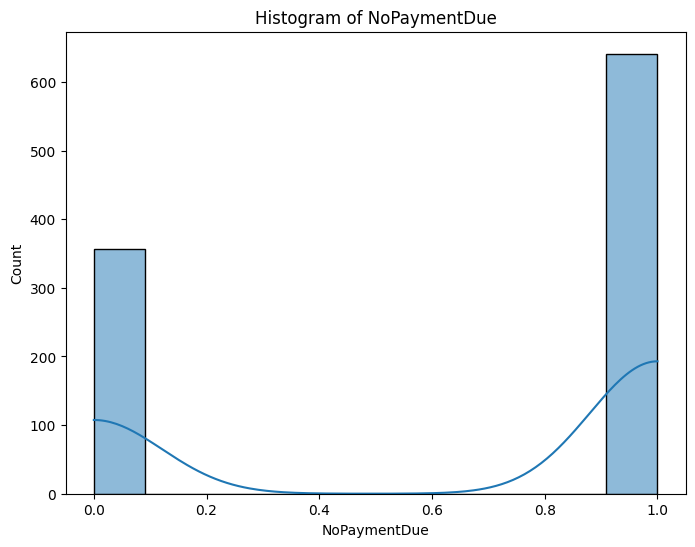

In [36]:
data_exploration(df_a1, 'NoPaymentDue') # Target variable is imbalanced
# Model accuracy must be greater than 0.64 to be considered better than the baseline model

### Generate Test Design

#### Data Splitting

In [37]:
# Split the data into training and testing sets - 70% training, 30% testing - Using stratified sampling
X = df_a1.drop('NoPaymentDue', axis=1)
y = df_a1['NoPaymentDue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666, stratify=y)

print("The length of training set:", len(X_train))
print("The length of testing  set:", len(y_test))

The length of training set: 698
The length of testing  set: 300


### XGBOOST

We will experiment with an XGBoost Classifer in Sklearn.

In [41]:
# Train the XGB model
xgb_model = xgb.XGBClassifier(random_state=666) # Initialize xgboost classifier 

# Fit the model to the training data
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test) # Get predictions

# Evaluate the performance of the XGB Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_xgb))

Confusion Matrix:
[[102   5]
 [  1 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       107
           1       0.97      0.99      0.98       193

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300


Accuracy Score:
0.98


In [42]:
# Perform 5-fold cross-validation on the scaled data
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores_xgb)
print("Average Cross-Validation Score:", np.mean(cv_scores_xgb))

# Check for overfitting by comparing performance on the training and test sets
y_pred_train_xgb = xgb_model.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, y_pred_train_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGB Training Set Accuracy:", train_accuracy_xgb)
print("XGB Test Set Accuracy:", test_accuracy_xgb)

if train_accuracy_xgb > test_accuracy_xgb:
    difference_xgb = train_accuracy_xgb - test_accuracy_xgb
    print("The training accuracy is higher than test accuracy by", difference_xgb)
    if difference_xgb > 0.1:  # Arbitrary threshold, adjust as needed
        print("There might be overfitting")
    else:
        print("The difference is small, overfitting might not be an issue")
else:
    print("Overfitting is not an issue")


Cross-Validation Scores: [0.975      0.99       0.975      0.9798995  0.96984925]
Average Cross-Validation Score: 0.9779497487437185
XGB Training Set Accuracy: 1.0
XGB Test Set Accuracy: 0.98
The training accuracy is higher than test accuracy by 0.020000000000000018
The difference is small, overfitting might not be an issue


Because the difference is by 0.02, overfitting might not be an issue, so we'll keep this model.

### Naive Bayes

In [44]:
# Train the GNB model
gnb_model = GaussianNB() # Initialize GNB classifier 

# Fit the model to the training data
gnb_model.fit(X_train, y_train)
y_pred_gnb = gnb_model.predict(X_test) # Get predictions

# Evaluate the performance of the GNB Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gnb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_gnb))

Confusion Matrix:
[[107   0]
 [ 83 110]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       107
           1       1.00      0.57      0.73       193

    accuracy                           0.72       300
   macro avg       0.78      0.78      0.72       300
weighted avg       0.84      0.72      0.72       300


Accuracy Score:
0.7233333333333334


Though higher than the baseline, our GNB model is at 0.72. Let's try the Bernoulli NB.

In [50]:
# Train the BNB model
bnb_model = BernoulliNB() # Initialize BNB classifier 

# Fit the model to the training data
bnb_model.fit(X_train, y_train)
y_pred_bnb = bnb_model.predict(X_test) # Get predictions

# Evaluate the performance of the BNB Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bnb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bnb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_bnb))

Confusion Matrix:
[[ 70  37]
 [ 43 150]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       107
           1       0.80      0.78      0.79       193

    accuracy                           0.73       300
   macro avg       0.71      0.72      0.71       300
weighted avg       0.74      0.73      0.73       300


Accuracy Score:
0.7333333333333333


Though also higher than the baseline, our BNB model came in at 0.73 which is better than the GNB model, so let's see if we can improve this model by tuning the hyperparameters. Since we do not have any requirements for the model, we'll also use RandomizedSearchCV to find the best combination of parameters from a specified range.

#### Hyperparameter Tuning BNB Model

In [51]:
# Let's find our best parameters
param_space = {'alpha': [0.01, 0.1, 1.0, 10.0],
              'fit_prior': [True, False]}

# Let's apply our best alpha to see if we can improve our model
random_bnb = BernoulliNB() # Initialize BNB classifier
random_search = RandomizedSearchCV(random_bnb, param_space, n_iter=10, cv=5, random_state=666, scoring ='accuracy')

# Fit to our training data
random_search.fit(X_train, y_train)

# Identify the best alpha
random_best_parameters = random_search.best_params_
print('Best BNB hyperparameters:', random_best_parameters)


Best BNB hyperparameters: {'fit_prior': False, 'alpha': 0.01}


In [52]:
# Let's save our best model with our best parameters, so we can generate predictions
best_bnb_model = random_search.best_estimator_ # Add in our best parameters

# Get predictions
y_pred_best_bnb = best_bnb_model.predict(X_test)

# Display the confusion matrix, classification report, and accuracy score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_bnb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_bnb))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_best_bnb))

Confusion Matrix:
[[104   3]
 [ 79 114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       107
           1       0.97      0.59      0.74       193

    accuracy                           0.73       300
   macro avg       0.77      0.78      0.73       300
weighted avg       0.83      0.73      0.73       300


Accuracy Score:
0.7266666666666667


Even after hypertuning, the Bernoulli Naive Bayes models drops from 0.73 to 0.72. This model might be too simple hence low performance.